In [1]:
import bw2data as bd
import bw2calc as bc
import bw2analyzer as ba
import bw2io as bi
from tqdm import tqdm

import numpy as np
import os
import sys
import time

import pickle

import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "DejaVu Sans",
    "font.size": 14
})
import ast



from pathlib import Path
from typing import Union, Optional
import datetime
import hashlib
import json
import pandas as pd
import re
import unicodedata
import uuid

In [2]:
%%time
bi.restore_project_directory("/Users/ajakobs/Documents/data/hybrid-eco-exio/CH_household_hybrid_project_eco391_ex381_march_28.tar.gz")


Restoring project backup archive - this could take a few minutes...
CPU times: user 12.2 s, sys: 3.06 s, total: 15.3 s
Wall time: 16.2 s


'eco-ex-March-2023'

In [3]:
bd.projects.set_current("eco-ex-March-2023")

In [4]:
bd.databases

Databases dictionary with 5 object(s):
	biosphere3
	ecoinvent-3.9.1-cutoff
	exiobase-3.8.1-monetary
	exiobase-3.8.1-monetary biosphere
	swiss consumption 1.0

In [5]:
co = bd.Database("swiss consumption 1.0")

In [6]:
act_list = [act for act in sorted(co, key=lambda x: x['name'])]
len(act_list)

314

In [7]:
act_dict = {act['name']:i for i,act in enumerate(act_list)}

In [8]:
act_dict['ch hh average consumption disaggregated, years 151617']

207

In [9]:
def read_in_results_array(results_dir):
    dirlist = os.listdir(results_dir)
    act_names_file = [f for f in dirlist if not f.endswith('.npy')][0]
    # remove act names file from dirlist
    _ = dirlist.pop(dirlist.index(act_names_file))
    with open(os.path.join(results_dir,act_names_file),'r') as fh:
        activity_names = [l.rstrip() for l in fh]

    for i,f in enumerate(dirlist):
        if i==0:
            a = np.load(os.path.join(results_dir,f), allow_pickle=True)
            full_array = np.zeros((len(dirlist),*a.shape))
            full_array[i,:,:]= a
        else:
            full_array[i,:,:]= np.load(os.path.join(results_dir,f), allow_pickle=True)
    return full_array, activity_names


In [11]:
%%time
# Read in inventory results
results_dir = '/Users/ajakobs/Documents/CCL/results/MC_results_directly_sampled/'
array_samples, activity_names = read_in_results_array(results_dir)

CPU times: user 3.13 s, sys: 4.77 s, total: 7.9 s
Wall time: 14.1 s


In [12]:
array_samples.shape

(1000, 2423, 314)

In [13]:
# grab an activity and run an lcia to build the characterisation matrix
act = [act for act in co if act['name']=='ch hh average consumption disaggregated, years 151617'][0]
act

'ch hh average consumption disaggregated, years 151617' (1 month of consumption, CH, None)

In [14]:
ipcc_2021 = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
ipcc_2021

('IPCC 2021', 'climate change', 'global warming potential (GWP100)')

In [15]:
eco_total = ('Ecological Scarcity 2021', 'total', 'UBP')
eco_total

('Ecological Scarcity 2021', 'total', 'UBP')

In [16]:
%%time
# Do one lca calcuation to build the characterisation matrix
lca = bc.LCA({act: 1}, method=ipcc_2021)
lca.lci()
lca.lcia()
lca.score

CPU times: user 4.97 s, sys: 250 ms, total: 5.22 s
Wall time: 1.81 s


1796.4146141617975

In [17]:
%%time
# now calculate all the scores for ipcc 2021
cc_impacts_samples = lca.characterization_matrix.sum(axis=0).A.dot(array_samples)

CPU times: user 3.43 s, sys: 4.74 s, total: 8.17 s
Wall time: 8.77 s


In [18]:
%%time
# now switch method to create a new characterisation method
lca.switch_method(eco_total)
lca.lcia()
lca.score/1e6

CPU times: user 10.6 ms, sys: 3.71 ms, total: 14.3 ms
Wall time: 13.3 ms


7.1307714692810436

In [19]:
%%time
# now calculate all the scores for ecological scarcity total 2021
es_total_impacts_samples = lca.characterization_matrix.sum(axis=0).A.dot(array_samples)

CPU times: user 2.26 s, sys: 19 ms, total: 2.28 s
Wall time: 2.29 s


In [ ]:
eco_landuse = ('Ecological Scarcity 2021', 'land use', 'land use')
eco_landuse

In [ ]:
%%time
# now switch method to create a new characterisation method
lca.switch_method(eco_landuse)
lca.lcia()
lca.score/1e6

In [ ]:
%%time
# now calculate all the scores for ecological scarcity land use 2021
es_lu_impacts_samples = lca.characterization_matrix.sum(axis=0).A.dot(array_samples)

## now define functional units

In [20]:
# load cluster activities
# grep simple clusters
clusters_simple = [act for act in co if "household cluster" in act['name'].lower() if len(act['name'])==45]
clusters_simple.sort()
income_groups = clusters_simple[:6]
household_types = clusters_simple[-7:]
household_types

['household cluster a consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster b consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster c consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster d consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster e consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster f consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster g consumption, years 151617' (1 month of consumption, CH, None)]

In [21]:
# load necessary dictionaries with cluster names
with open('./write_files/households_categories_names_dict_extended.pickle', 'rb') as fh:
    categories_names_dict = pickle.load(fh)
with open('./write_files/households_categories_labels_dict_extended.pickle', 'rb') as fh:
    category_labels_dict = pickle.load(fh)
mapping_dict = {value:categories_names_dict[cat][key] for cat in category_labels_dict.keys() for (key,value) in category_labels_dict[cat].items()}
mapping_dict

{'A': 'Genferseeregion',
 'B': 'Espace Mittelland',
 'C': 'Nordwestschweiz',
 'D': 'Zürich',
 'E': 'Ostschweiz',
 'F': 'Zentralschweiz',
 'G': 'Tessin',
 'a': 'Einpersonenhaushalte unter 65',
 'b': 'Einpersonenhaushalte ab 65',
 'c': 'Paarhaushalte (beide unter 65) ohne weitere Haushaltsmitglieder',
 'd': 'Paarhaushalte (mindestens eine Person ab 65) ohne weitere Haushaltsmitglieder',
 'e': 'Einelternhaushalte mit Kindern (mindestens eines unter 25) ohne weitere Haushaltsmitglieder',
 'f': 'Paarhaushalte mit Kindern (mindestens eines unter 25) ohne weitere Haushaltsmitglieder',
 'g': 'Übrige Haushaltstypen',
 '1': '1. Fünftel (< 4 914)',
 '2': '2. Fünftel (4 914 – 7 264)',
 '3': '3. Fünftel (7 265 – 9 990)',
 '4': '4. Fünftel (9 991 – 13 621)',
 '5': '5. Fünftel (13 622 - 26 658)',
 '6': 'Top 2% (>= 26 658)'}

In [22]:
hh_type_indics = [act_dict[hh['name']] for hh in household_types]
hh_type_indics

[289, 294, 297, 302, 307, 308, 313]

In [23]:
hh_size = np.array([hh['ppl_per_household'] for hh in household_types])
hh_size

array([1.        , 1.        , 2.        , 2.        , 2.60135135,
       3.86307692, 3.07344633])

In [24]:
household_types

['household cluster a consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster b consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster c consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster d consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster e consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster f consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster g consumption, years 151617' (1 month of consumption, CH, None)]

In [25]:
income_groups

['household cluster 1 consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster 2 consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster 3 consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster 4 consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster 5 consumption, years 151617' (1 month of consumption, CH, None),
 'household cluster 6 consumption, years 151617' (1 month of consumption, CH, None)]

## now plot some results

In [26]:
def plot_hists(data, ave, method):
    hists = []
    bins=np.linspace(*np.percentile(data,q=[0.5,99.5]),30)
    hists.append(plt.hist(ave,bins=bins,histtype='step', color='k', ls='-', density=True,alpha=1))
    print(ave.mean(), np.median(ave), np.std(ave))
    htype = ['stepfilled', 'step', 'stepfilled', 'step', 'stepfilled', 'step', 'stepfilled', 'step', 'stepfilled']
    alpha = [0.5, 1, 0.5, 1, 0.5, 1, 0.5, 1, 0.5, 1, 0.5, 1, 0.5]
    for i in range(data.shape[1]):
        hists.append(plt.hist(data[:,i], bins=bins, histtype='stepfilled', ls='-', alpha=0.4, density=True))
        # plt.hist(data[:,i], bins=bins, histtype='step', ls='-', alpha=0.4, density=True)
        print(data[:,i].mean(), np.median(data[:,i]), np.std(data[:,i]))
    plt.ylabel('Probability density')
    plt.xlabel(f'{method[2]} [{bd.methods[method]["unit"]}]')
    plt.show()
    return hists

1923.077575475649 1792.075475717199 589.0341104983393
1142.325217860818 1071.4164648408932 307.4898775238121
1495.2431968590333 1398.5372461556444 413.1374114785048
1863.4853320437264 1743.9103193069384 560.2264272683241
2193.4569262797863 2070.266258681777 577.2325418288132
2670.023657739007 2554.531339343809 624.4327375543132
3414.8651926500715 3263.58845685193 849.4818442532837


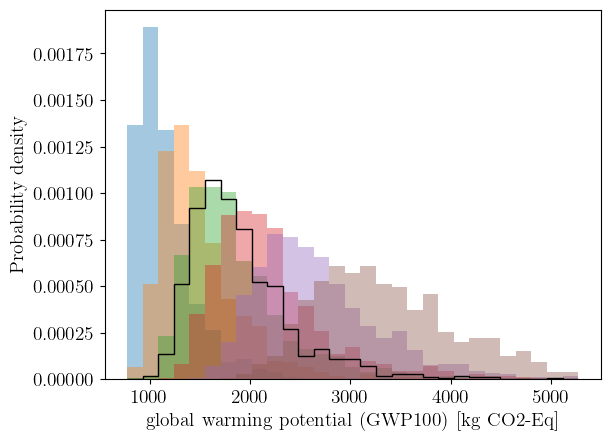

In [27]:
hists = plot_hists(cc_impacts_samples[0,:,208:214],cc_impacts_samples[0,:,207],ipcc_2021)

#### the above is not very informative so lets do this different

In [28]:
# first calculate the per person cclimate impacts for the different household types incl average households
cc_hh = np.divide(cc_impacts_samples[0,:,hh_type_indics].T,hh_size)*12
cc_ave = cc_impacts_samples[0,:,207:208]/2.24*12
print(cc_hh.shape, cc_ave.shape)
cc_annual = np.concatenate((cc_ave, cc_hh), axis=1)
group_labels = ['Average household'] + [mapping_dict[hh['name'].replace('household cluster ','')[0]] for hh in household_types]
group_labels

(1000, 7) (1000, 1)


['Average household',
 'Einpersonenhaushalte unter 65',
 'Einpersonenhaushalte ab 65',
 'Paarhaushalte (beide unter 65) ohne weitere Haushaltsmitglieder',
 'Paarhaushalte (mindestens eine Person ab 65) ohne weitere Haushaltsmitglieder',
 'Einelternhaushalte mit Kindern (mindestens eines unter 25) ohne weitere Haushaltsmitglieder',
 'Paarhaushalte mit Kindern (mindestens eines unter 25) ohne weitere Haushaltsmitglieder',
 'Übrige Haushaltstypen']

In [29]:
# define english labels
household_labels = [
    r'Average',
    r'Single person $<$65y',
    r'Single person $\geq$65y',
    r'Couple $<$65y',
    r'Couple, min 1 person $\geq$65y',
    r'Single parents, min 1 child $<$25y',
    r'Couple w. children, min 1 child $<$25y',
    r'Other']

In [30]:
# define color scheme
# colors = ['#66c2a5','#fc8d62','#8da0cb']
# below is the prism color scheme from plotly: plotly.colors.qualitative.Prism
colors = ['rgb(95, 70, 144)',
 'rgb(29, 105, 150)',
 'rgb(56, 166, 165)',
 'rgb(15, 133, 84)',
 'rgb(115, 175, 72)',
 'rgb(237, 173, 8)',
 'rgb(225, 124, 5)',
 'rgb(204, 80, 62)',
 'rgb(148, 52, 110)',
 'rgb(111, 64, 112)',
 'rgb(102, 102, 102)']
colors = [c.replace('rgb','') for c in colors]
colors = [ast.literal_eval(color) for color in colors]
colors = [tuple(np.array(color)/255) for color in colors]

In [31]:
colors

[(0.37254901960784315, 0.27450980392156865, 0.5647058823529412),
 (0.11372549019607843, 0.4117647058823529, 0.5882352941176471),
 (0.2196078431372549, 0.6509803921568628, 0.6470588235294118),
 (0.058823529411764705, 0.5215686274509804, 0.32941176470588235),
 (0.45098039215686275, 0.6862745098039216, 0.2823529411764706),
 (0.9294117647058824, 0.6784313725490196, 0.03137254901960784),
 (0.8823529411764706, 0.48627450980392156, 0.0196078431372549),
 (0.8, 0.3137254901960784, 0.24313725490196078),
 (0.5803921568627451, 0.20392156862745098, 0.43137254901960786),
 (0.43529411764705883, 0.25098039215686274, 0.4392156862745098),
 (0.4, 0.4, 0.4)]

In [32]:
def plot_multi_hist(data, labels, method, unit, categories, colors, add_kde=False, save_dir=None, save=True, file_name=None):
    sns.set_theme()
    plt.rcParams.update({
    "text.usetex": True,
    "font.family": "DejaVu Sans",
    "font.size": 14
})
    fig,axes = plt.subplots(data.shape[1],1)
    supax = fig.add_subplot(111, frameon=False)
    supax.set_xticklabels([]), supax.set_yticklabels([]), supax.set_xticks([]), supax.set_yticks([])

    bins = bins=np.linspace(*np.percentile(data,q=[1,99]),50)
    for i,ax in enumerate(axes[::-1]):
        ax.hist(data[:,i], bins=bins, histtype='stepfilled', color=colors[0], alpha=1, density=True)
        if add_kde:
            sns.kdeplot(cc_annual[:,i], ax=ax, cut=0, alpha=1, c='k', ls='-')
        ax.axvline(np.mean(data[:,i]), 0,1, c=colors[1], ls='-')
        ax.axvline(np.median(data[:,i]), 0,1, c=colors[2], ls='--')
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xlim(0.8*bins[0],bins[-1]+(1-0.8)*bins[0])
        # set secondary y labels
        twax = ax.twinx()
        twax.set_yticks([0.5], [labels[i]])
        twax.tick_params(axis='y', which='both', length=0)
        twax.grid(visible=False, axis='y')

        if not i==0:
            ax.set_xticklabels([])
        if i==0:
            ax.set_xlabel(f'{method} [{unit}]')
    supax.set_ylabel('Probability density')      
    fig.subplots_adjust(wspace=0, hspace=0)
    if save:
        if save_dir is None:
            save_dir = '/Users/ajakobs/Documents/CCL/results/figures/'
        if file_name is None:
            if categories is not None:
                file_name = f'{method}_distributions_{categories}.pdf'
        if file_name is not None:
            fig_path = os.path.join(save_dir, file_name)
            fig.savefig(fig_path, bbox_inches = "tight")
        else:
            print('To save please provide file_name or categories')
    plt.show()
    sns.reset_defaults()
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "DejaVu Sans",
        "font.size": 14
    })

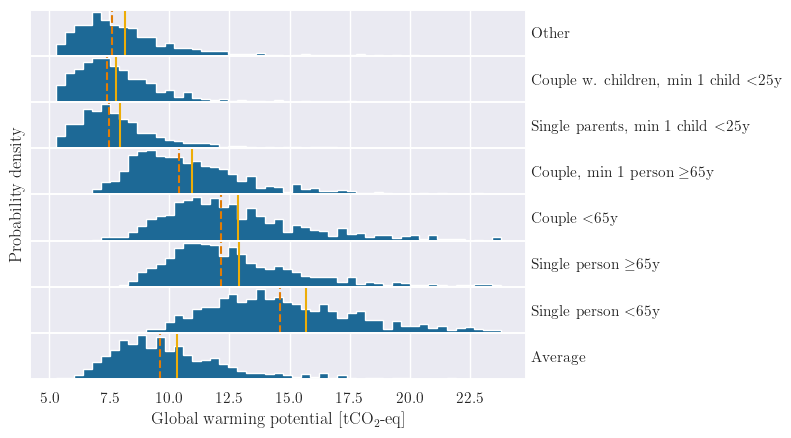

In [33]:
plot_multi_hist(cc_annual/1e3, household_labels, method='Global warming potential', unit='tCO$_2$-eq', categories='householdTypes',
                colors=[colors[1], colors[5], colors[6]], add_kde=False, save=False, file_name='gwp100_distributions_householdtypes.pdf')

In [46]:
# first calculate the per person cclimate impacts for the different household types incl average households
es_hh = np.divide(es_total_impacts_samples[0,:,hh_type_indics].T,hh_size)*12
es_ave = es_total_impacts_samples[0,:,207:208]/2.24*12
print(es_hh.shape, es_ave.shape)
es_annual = np.concatenate((es_ave, es_hh), axis=1)

(1000, 7) (1000, 1)


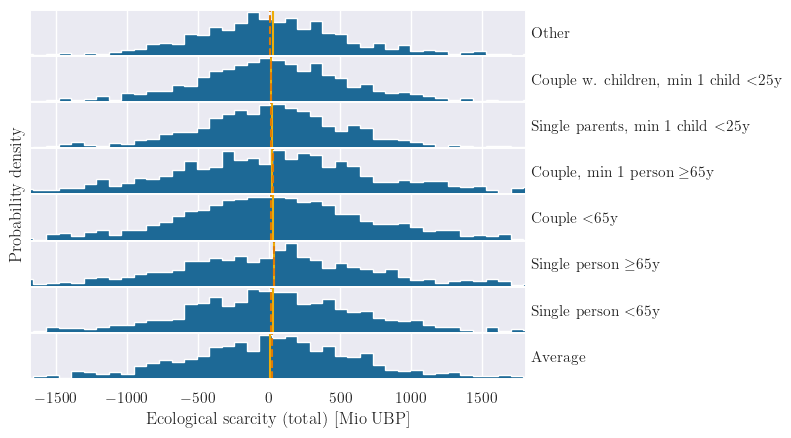

In [47]:
# plot ecological scacity total
plot_multi_hist(es_annual/1e6, household_labels, method='Ecological scarcity (total)', unit='Mio UBP',
                categories='householdTypes', colors=[colors[1], colors[5], colors[6]], add_kde=False, 
                save=False, file_name='ecoscarcity_distributions_householdtypes.pdf')

In [227]:
# first calculate the per person cclimate impacts for the different household types incl average households
es_lu_hh = np.divide(es_lu_impacts_samples[0,:,hh_type_indics].T,hh_size)*12
es_lu_ave = es_lu_impacts_samples[0,:,207:208]/2.24*12
print(es_lu_hh.shape, es_lu_ave.shape)
es_lu_annual = np.concatenate((es_lu_ave, es_lu_hh), axis=1)

(1000, 7) (1000, 1)


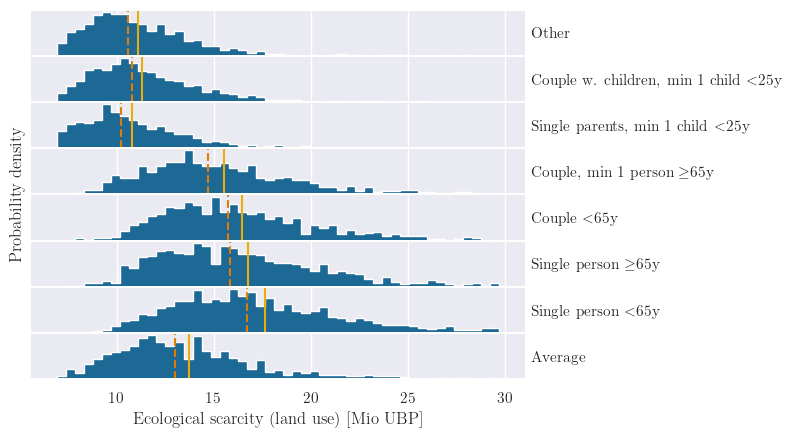

In [324]:
# plot ecological scacity total
plot_multi_hist(es_lu_annual/1e6, household_labels, method='Ecological scarcity (land use)', unit='Mio UBP', categories='householdTypes', colors=[colors[1], colors[5], colors[6]], add_kde=False, file_name='ecoscarcity_landuse_distributions_householdtypes.pdf')

## Write data packages for results

In [34]:
#first create dictionary providing the activity name based on index
rev_act_dict = {index:name for name, index in act_dict.items()}


In [50]:
co.name

'swiss consumption 1.0'

In [ ]:
# average nr of people per household and average monthly income per household
n_people_ave = 2.24
income_average = 9938

In [75]:
def make_dataframe(data, names_dict, impact_method, units):
    # make sure that the data matches the dictionary length
    assert data.shape[1] == len(names_dict)
    for i in range(len(names_dict)):
        raw_name = names_dict[i]
        act = bd.get_node(name=raw_name, database=co.name)
        product_unit = None
        if raw_name.startswith("ch hh average consumption"):
            n_people = 2.24  # averag nr of people per household
            income = 9938  # averag monthly gross income per household in CHF
        elif raw_name.startswith("household cluster"):
            n_people = act['ppl_per_household']  # ave nr of people per household in cluster
            income = act['income_per_household']  # ave monthly gross income per household in cluster in CHF
        else:
            product_unit = act['unit']  # for the individual products save the unit
            n_people = np.NaN  # for the individual products this is not defined
            income = np.NaN  # for the individual products this is not defined
        if i == 0:
            results = [{
                "name":clean_name(names_dict[i]),
                "product_unit": product_unit,
                "houshold_size" : n_people,
                "gross_income": income,
                "mean": "{:.4g}".format(np.mean(data[:,i])),
                "median": "{:.4g}".format(np.median(data[:,i])),
                "std": "{:.4g}".format(np.std(data[:,i])),
                "method": impact_method,
                "unit": units
            }]
        else:
            results.append({
                "name":clean_name(names_dict[i]),
                "product_unit": product_unit,
                "houshold_size" : n_people,
                "gross_income": income,
                "mean": "{:.4g}".format(np.mean(data[:,i])),
                "median": "{:.4g}".format(np.median(data[:,i])),
                "std": "{:.4g}".format(np.std(data[:,i])),
                "method": impact_method,
                "unit": units
            })
    return pd.DataFrame(results)

In [36]:
def clean_name(string):
    return string.replace(", years 151617", "")\
                 .replace("consumption", "")\
                 .replace("disaggregated", "").strip()

In [37]:
re_slugify = re.compile(r"[^\w\s-]", re.UNICODE)
SUBSTITUTION_RE = re.compile(r"[^\w\-\.]")
MULTI_RE = re.compile(r"_{2,}")


def clean_datapackage_name(name: str) -> str:
    """Clean string ``name`` of characters not allowed in data package names.
    Replaces with underscores, and drops multiple underscores."""
    return re.sub(MULTI_RE, "_", re.sub(SUBSTITUTION_RE, "_", name).strip("_")).strip()

In [38]:
def safe_filename(
    string: Union[str, bytes], add_hash: bool = True, full: bool = False
) -> str:
    """Convert arbitrary strings to make them safe for filenames. Substitutes strange characters, and uses unicode normalization.
    if `add_hash`, appends hash of `string` to avoid name collisions.
    From http://stackoverflow.com/questions/295135/turn-a-string-into-a-valid-filename-in-python"""
    safe = re.sub(
        r"[-\s]+",
        "-",
        str(re_slugify.sub("", unicodedata.normalize("NFKD", str(string))).strip()),
    )
    if add_hash:
        if isinstance(string, str):
            string = string.encode("utf8")
        if full:
            safe += "." + hashlib.md5(string).hexdigest()
        else:
            safe += "." + hashlib.md5(string).hexdigest()[:8]
    return safe

In [68]:
def get_metadata_for_resource(filename):
    return {
        "path": f"{filename}.csv",
        "profile": "tabular-data-resource",
        "mediatype": "text/csv",
        "schema": {
            "fields": [
                # Insert your own fields here; see https://dataprotocols.org/json-table-schema/#field-descriptors for spec
                {'name': 'name', 'type': 'string'},
                {'name': 'product_unit', 'type': 'string'},
                {'name': 'household_size', 'type': 'number'},
                {'name': 'gross_income', 'type': 'number'},
                {'name': 'method', 'type': 'string'},
                {'name': 'unit', 'type': 'string'},
                {'name': 'mean', 'type': 'number'},
                {'name': 'median', 'type': 'number'},
                {'name': 'std', 'type': 'number'}
            ],
        },
    }

In [40]:
LICENSE = {
    "name": "CC-BY-4.0",
    "path": "https://creativecommons.org/licenses/by/4.0/legalcode",
    "title": "Creative Commons Attribution 4.0 International",
}

In [84]:
def to_datapackage(
    dirpath: Path,
    resources: list,
    resources_metadata: list,
    name: str,
    author: str,
    description: str,
    version: Optional[str] = None,
    id_: Optional[str] = None,
    licenses: Optional[list] = None,
):
    dirpath.mkdir(parents=True, exist_ok=True)

    name = clean_datapackage_name(name)

    metadata = {
        "profile": "tabular-data-package",  # https://dataprotocols.org/tabular-data-package/
        "name": name,
        "description": description,
        "id": id_ or uuid.uuid4().hex,
        "licenses": licenses or [LICENSE],
        "resources": resources_metadata,
        "created": datetime.datetime.utcnow().isoformat("T") + "Z",
    }

    json.dump(metadata, open(dirpath / f"metadata_{name.replace('.csv','')}.json", "w"), indent=2, ensure_ascii=False)
    
    for df, meta in zip(resources, resources_metadata):
        df.to_csv(dirpath / meta['path'], index=False)

## Save GWP100 results to datapackage

In [78]:
%%time
gwp_results_df = make_dataframe(cc_impacts_samples[0,:,:], rev_act_dict, impact_method='GWP100 IPCC 2021', units='kg CO2-eq')

CPU times: user 255 ms, sys: 11.1 ms, total: 266 ms
Wall time: 266 ms


In [79]:
gwp_results_df

,name,product_unit,houshold_size,gross_income,mean,median,std,method,unit
0,Accommodation services,CHF,NaN,NaN,0.174,0.174,5.551e-17,GWP100 IPCC 2021,kg CO2-eq
1,"Air travels, tickets",CHF,NaN,NaN,0.971,0.971,3.331e-16,GWP100 IPCC 2021,kg CO2-eq
2,Alcoholic and non-alcoholic beer,litre,NaN,NaN,0.1026,0.1023,0.007802,GWP100 IPCC 2021,kg CO2-eq
3,Alcoholic and non-alcoholic liqueurs and lique...,litre,NaN,NaN,0.4941,0.4989,1.11,GWP100 IPCC 2021,kg CO2-eq
4,Apples,kilogram,NaN,NaN,0.3837,0.3793,0.3062,GWP100 IPCC 2021,kg CO2-eq
...,...,...,...,...,...,...,...,...,...
309,household cluster f2,None,3.781991,6380.456853,1737,1664,400.1,GWP100 IPCC 2021,kg CO2-eq
310,household cluster f3,None,3.830571,8688.641724,2072,1986,474.1,GWP100 IPCC 2021,kg CO2-eq
311,household cluster f4,None,3.858182,11698.914336,2373,2277,535.8,GWP100 IPCC 2021,kg CO2-eq
312,household cluster f5,None,3.908530,19629.199431,3021,2909,666.4,GWP100 IPCC 2021,kg CO2-eq


In [85]:
%%time
description='IPCC 2021 GWP100 results for NFP 73 CCL Data Transparency for Sustainbility project.\
             GWP100 impacts for all product categories from the household expenditure survey, followed by the monthly gwp100 impact\
             for the average household as well as various household clusters. Both impacts and gross income are monthly per household values.'
to_datapackage(
    Path('/Users/ajakobs/Documents/CCL/results/datapackages/'),
    [gwp_results_df], 
    [{'path': 'nfp73-ccl-preliminary-results-ipcc-gwp-april-2023.csv'}],
    name='nfp73-ccl-ipcc-2021-gwp100-results',
    author='PSI',
    description=description,
    version="1.0",
)

CPU times: user 4.11 ms, sys: 2.49 ms, total: 6.6 ms
Wall time: 5.43 ms


## Save Ecological Scarcity results to datapackage

In [81]:
%%time
# Now the same for ecological scarcity
es_results_df = make_dataframe(es_total_impacts_samples[0,:,:], rev_act_dict, impact_method='Ecological Scarcity total 2021', units='UBP')


CPU times: user 258 ms, sys: 10.6 ms, total: 268 ms
Wall time: 267 ms


In [82]:
es_results_df

,name,product_unit,houshold_size,gross_income,mean,median,std,method,unit
0,Accommodation services,CHF,NaN,NaN,1072,1072,0,Ecological Scarcity total 2021,UBP
1,"Air travels, tickets",CHF,NaN,NaN,1783,1783,6.821e-13,Ecological Scarcity total 2021,UBP
2,Alcoholic and non-alcoholic beer,litre,NaN,NaN,958.5,958.5,513.1,Ecological Scarcity total 2021,UBP
3,Alcoholic and non-alcoholic liqueurs and lique...,litre,NaN,NaN,2148,2524,8753,Ecological Scarcity total 2021,UBP
4,Apples,kilogram,NaN,NaN,5886,5926,3792,Ecological Scarcity total 2021,UBP
...,...,...,...,...,...,...,...,...,...
309,household cluster f2,None,3.781991,6380.456853,8.692e+05,1.135e+06,1.639e+08,Ecological Scarcity total 2021,UBP
310,household cluster f3,None,3.830571,8688.641724,8.972e+05,2.664e+06,2.005e+08,Ecological Scarcity total 2021,UBP
311,household cluster f4,None,3.858182,11698.914336,1.758e+06,2.1e+06,1.944e+08,Ecological Scarcity total 2021,UBP
312,household cluster f5,None,3.908530,19629.199431,5.921e+06,3.651e+06,2.051e+08,Ecological Scarcity total 2021,UBP


In [86]:
%%time
description='Ecological Scarcity total 2021 results for NFP 73 CCL Data Transparency for Sustainbility project.\
             Ecological Scarcity impacts for all product categories from the household expenditure survey, followed by the monthly Ecological Scarcity\
             impact for the average household as well as various household clusters. Both impacts and gross income are monthly per household values.'
to_datapackage(
    Path('/Users/ajakobs/Documents/CCL/results/datapackages/'),
    [es_results_df], 
    [{'path': 'nfp73-ccl-preliminary-results-ecological-scarcity-2021-april-2023.csv'}],
    name='nfp73-ccl-ecological-scarcity-2021-results',
    author='PSI',
    description=description,
    version="1.0",
)

CPU times: user 4.47 ms, sys: 2.79 ms, total: 7.26 ms
Wall time: 5.58 ms


# Write cluster mapping dict to json file

In [87]:
with open('/Users/ajakobs/Documents/CCL/results/datapackages/household-cluster-label-mapping.json', 'w',encoding="utf-8") as file:
    json.dump(mapping_dict, file)